In [1]:
from Ornstein_Uhlenbeck import Ornstein_Uhlenbeck
import backtrader as bt
import numpy as np
import pandas as pd
import pyfolio as pf

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
stock_list = ['SLV', 'SIL']
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/{}.csv'.format(stock), index_col='Date', parse_dates=['Date'])

In [3]:
class PandasData(bt.feeds.PandasData):
    lines = ('open', 'high', 'low', 'close', 'adjclose', 'volume')
    params = (('datetime', None),
              ('open', 0),
              ('high', 1),
              ('low', 2),
              ('close', 3),
              ('adjclose', 4),
              ('volume', 5))

In [4]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.St = {stock_list[0]: np.array([]),
                   stock_list[1]: np.array([])
                   }
        self.model = Ornstein_Uhlenbeck(stock_dict[stock_list[0]]['Adj Close'].to_numpy(), 
                                        stock_dict[stock_list[1]]['Adj Close'].to_numpy())
        self.a = 0.1
        self.signal = 0
        self.pos = 0
    
    def signal_generation(self):
        if len(self.St[stock_list[0]]) < 252:
            return 0
        self.Xt = self.model.alpha * self.St[stock_list[0]][-1] - self.model.beta * self.St[stock_list[1]][-1]
        if self.signal == 1:
            signal = 0 if self.Xt >= self.model.mu else 1
        elif self.signal == -1:
            signal = 0 if self.Xt <= self.model.mu else -1
        else:
            if self.Xt > np.quantile(self.model.X, 1 - self.a):
                signal = -1
            elif self.Xt < np.quantile(self.model.X, self.a):
                signal = 1
            else:
                signal = 0
        return signal
        
    def close_positions(self):
        for data in self.datas:
            self.close(data=data)
            
    def next(self):
        for data in self.datas:
            self.St[data._name] = np.append(self.St[data._name], data.adjclose[0])

        if len(self.St[stock_list[0]]) != 0 and len(self.St[stock_list[0]]) % 252 == 0:
            self.model = Ornstein_Uhlenbeck(self.St[stock_list[0]][-252:], self.St[stock_list[1]][-252:])
            
        self.signal = self.signal_generation()
    
        if self.signal == 1:
            if self.pos == 0:
                self.buy(data=self.datas[0], size=cerebro.broker.get_value() * self.model.alpha)
                self.sell(data=self.datas[1], size=cerebro.broker.get_value() * self.model.beta)
        elif self.signal == -1:
            if self.pos == 0:
                self.sell(data=self.datas[0], size=cerebro.broker.get_value() * self.model.alpha)
                self.buy(data=self.datas[1], size=cerebro.broker.get_value() * self.model.beta)
        elif self.signal == 0:
            if self.pos != 0:
                self.close_positions()
        self.pos = self.signal

In [5]:
cerebro = bt.Cerebro()

data_feed_dict = {}
for stock in stock_list:
    data_feed_dict[stock] = PandasData(dataname=stock_dict[stock], name=stock)
    cerebro.adddata(data_feed_dict[stock])

cerebro.addstrategy(MyStrategy)
cerebro.broker.setcash(100000000)

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib

                    In-sample Out-of-sample        All
Annual return            0.0%          8.4%       7.5%
Cumulative returns       0.0%        105.6%     105.6%
Annual volatility        0.0%         19.9%      18.9%
Sharpe ratio              NaN      0.501404   0.475618
Calmar ratio              NaN       0.31961   0.286431
Stability                 0.0      0.891866   0.919271
Max drawdown             0.0%        -26.1%     -26.1%
Omega ratio               NaN      1.117527   1.117527
Sortino ratio             NaN       0.78645   0.746026
Skew                      NaN      2.045636   2.166159
Kurtosis                  NaN     39.462062  44.207807
Tail ratio                NaN      1.005601   1.020073
Daily value at risk      0.0%         -2.5%      -2.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.13,2016-03-01,2016-08-16,2017-05-04,308
1,25.74,2020-10-14,2021-02-22,NaT,NaN
2,19.61,2020-07-22,2020-08-10,2020-09-23,46
3,16.19,2020-04-06,2020-05-04,2020-07-22,78
4,11.56,2019-07-29,2019-09-04,2019-12-04,93


Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                              26.130712 2016-03-01  2016-08-16    2017-05-04   
1                              25.736813 2020-10-14  2021-02-22           NaT   
2                              19.613325 2020-07-22  2020-08-10    2020-09-23   
3                               16.19319 2020-04-06  2020-05-04    2020-07-22   
4                              11.557424 2019-07-29  2019-09-04    2019-12-04   

Worst drawdown periods Duration  
0                           308  
1                           NaN  
2                            46  
3                            78  
4                            93  


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1302: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=[is_returns, is_weekly, is_monthly],
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1318: UserWarning: set_tic

Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,-0.03%,-1.40%,1.07%
New Normal,0.04%,-12.63%,17.43%


Stress Events      mean        min        max
Apr14          0.000000   0.000000   0.000000
Oct14          0.000000   0.000000   0.000000
Fall2015      -0.025281  -1.398151   1.070832
New Normal     0.035601 -12.627353  17.427747


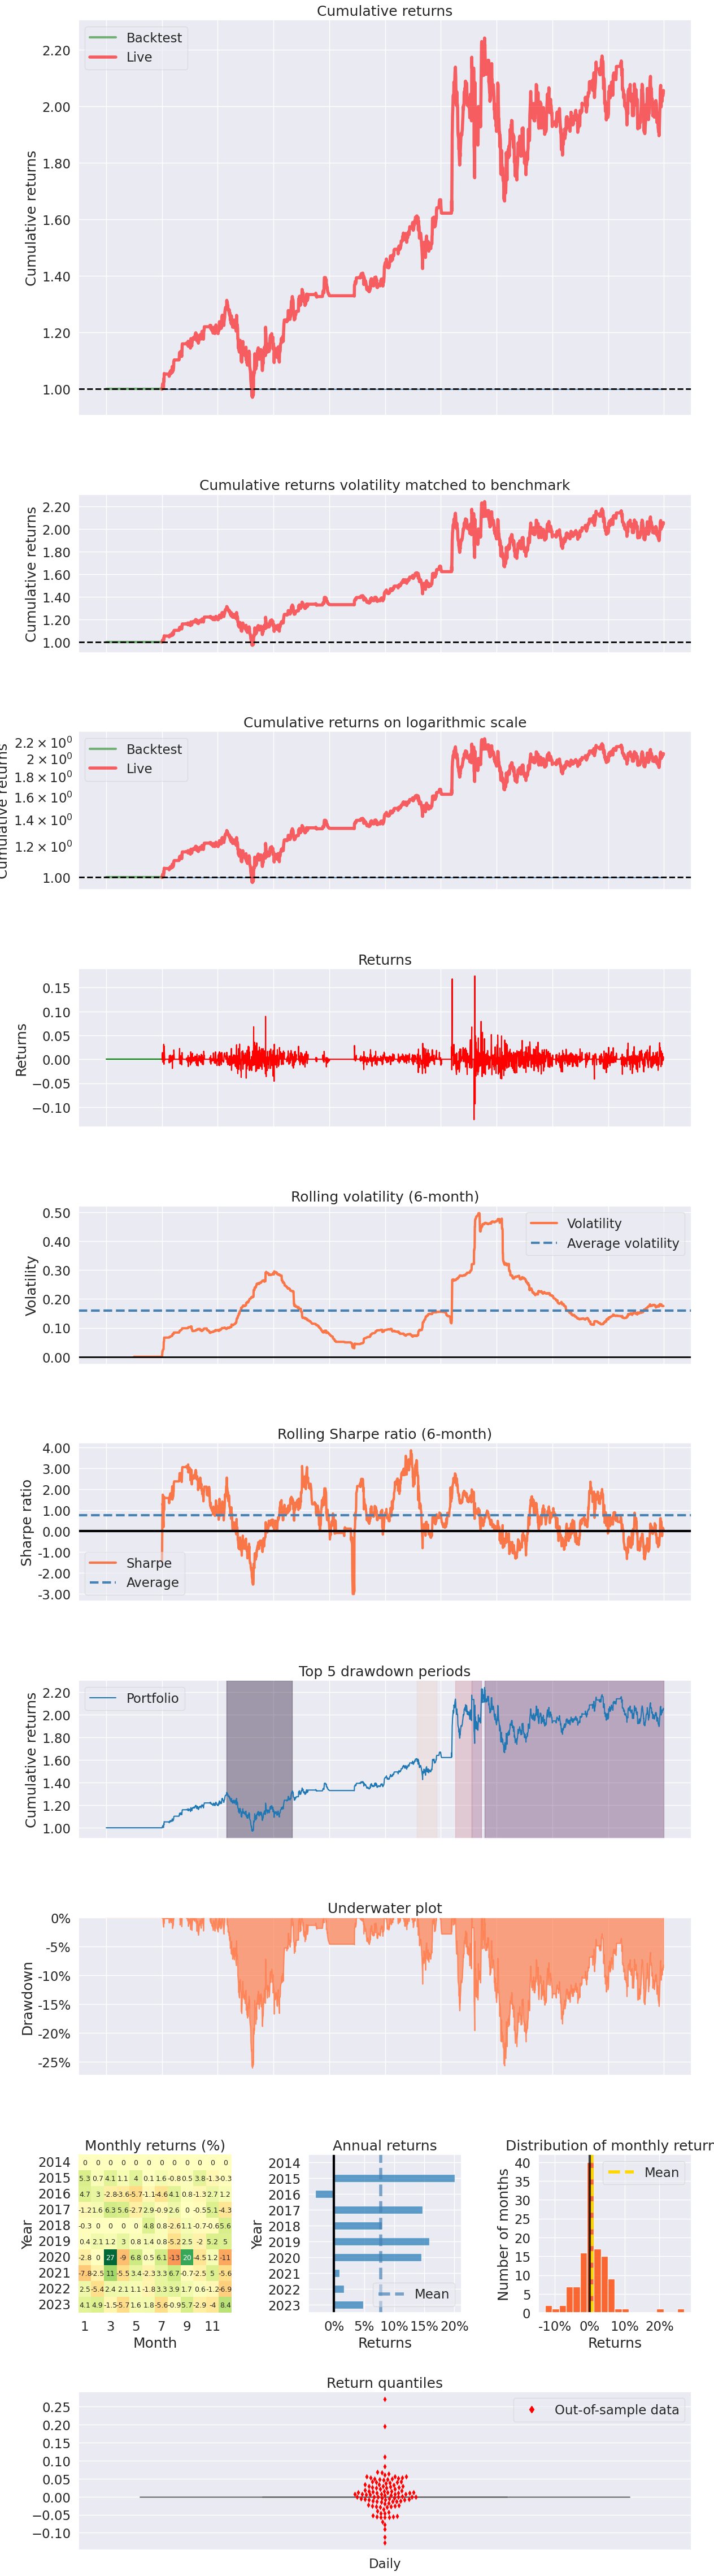

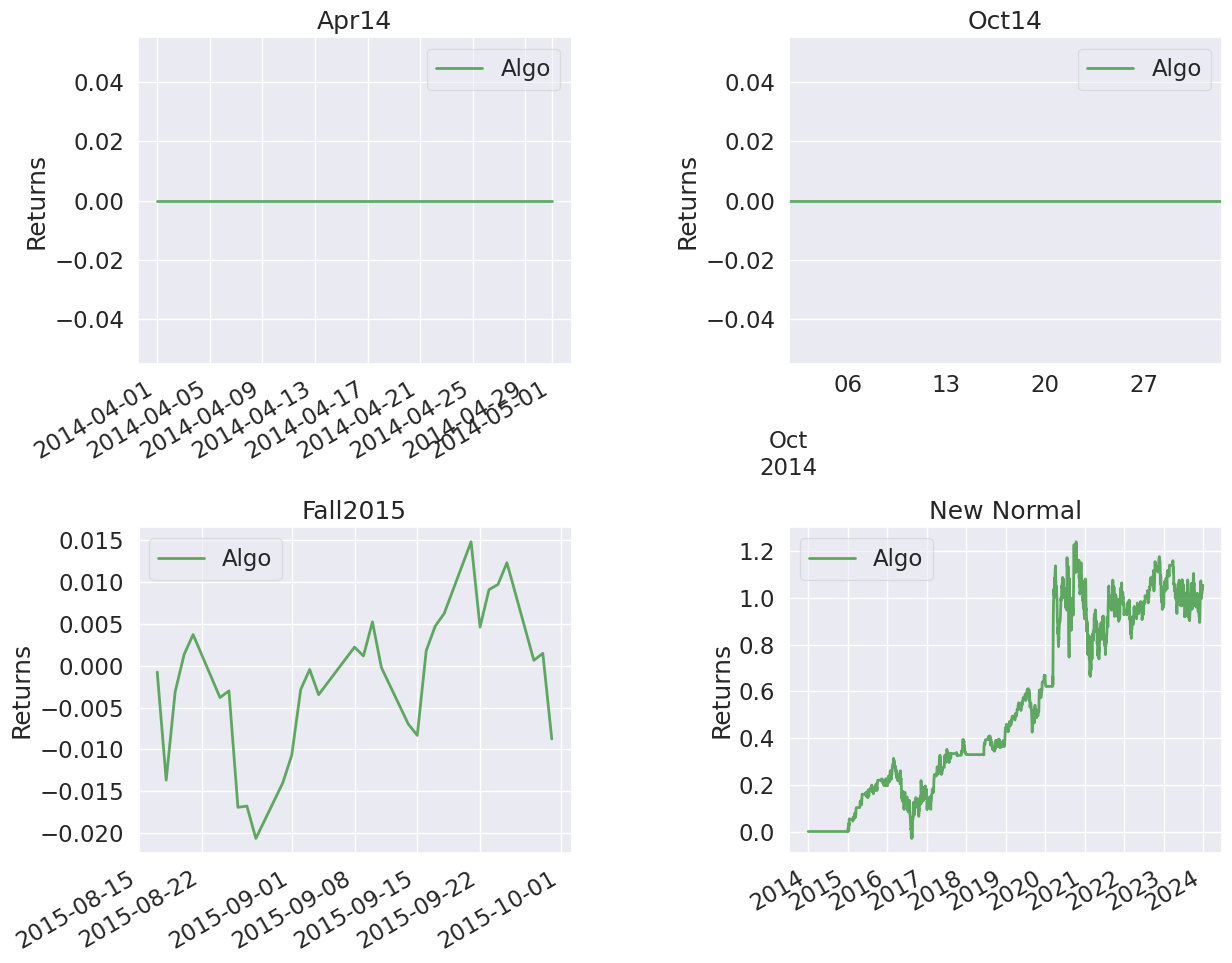

In [6]:
# Run the backtest
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
pf.create_full_tear_sheet(returns, live_start_date=stock_dict[stock_list[0]]['Adj Close'].index[252])